In [1]:
! pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.5.26

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os, glob
import PIL
from PIL import Image
import zipfile
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

In [3]:
# Unzip the dataset
zip_path = 'archive.zip'
extract_path = 'Image Classification'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
data_dir = 'Image Classification'
subfolders = os.listdir(data_dir)
subfolders

['covid', 'normal', 'pneumonia']

In [5]:
# Getting list of img file paths (no folders)
img_files = glob.glob(data_dir+"**/*/*")
len(img_files)

6939

In [6]:
img_files[0:5]

['Image Classification\\covid\\001.jpeg',
 'Image Classification\\covid\\002.jpeg',
 'Image Classification\\covid\\003.jpeg',
 'Image Classification\\covid\\004.jpeg',
 'Image Classification\\covid\\005.jpeg']

In [7]:
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(751, 873, 3)

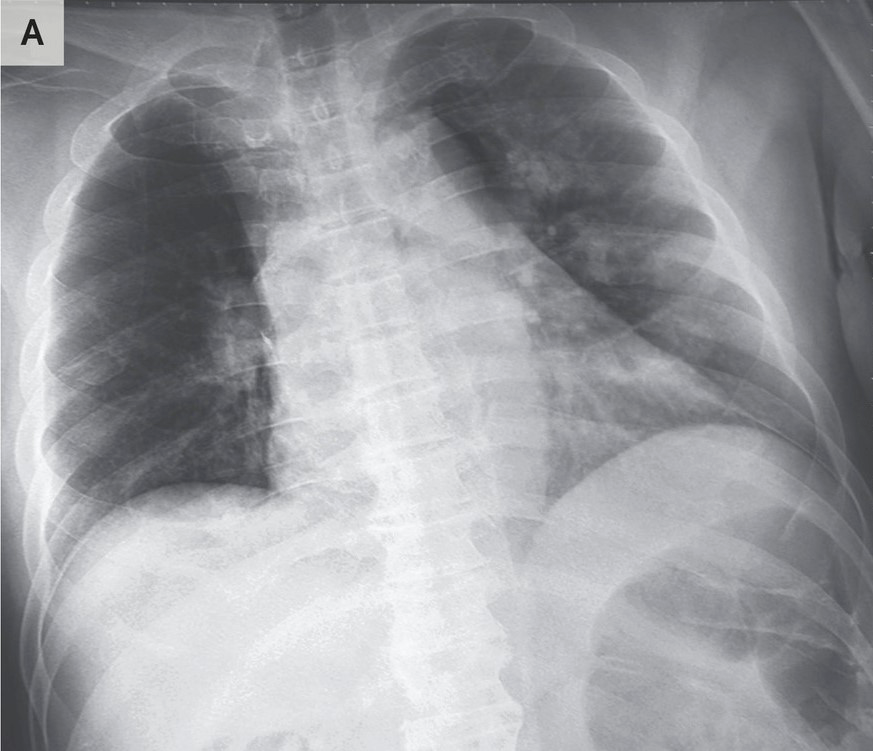

In [8]:
array_to_img(img_data)

##### Creating an image_dataset_from_directory

In [9]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 96
img_width = 96

# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds

Found 6902 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [10]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

216

In [11]:
# taking a sample batch to see batch shape
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 96, 96, 3])

In [12]:
# Preview y for first 5 of first batch
example_batch_y[0:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

In [13]:
# checking the class names
class_names = ds.class_names
class_names

['covid', 'normal', 'pneumonia']

In [14]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

3

In [15]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [16]:
# Individual image shape
input_shape = example_batch_imgs[0].shape

# Demo Unpacking shape
input_shape = [*input_shape]
input_shape

[96, 96, 3]

In [17]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1 
# Calculate the number of batches for training and validation data 
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 151 batches as training data
Use 43 batches as validation data
The remaining 22 batches will be used as test data.


In [18]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)

# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)

# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)

# Confirm the length of the training set
print(f"Length of training set: {len(train_ds)}")
# Confirm the length of the validation set
print(f"Length of validation set: {len(val_ds)}")
# Confirm the length of the testing data
print(f"Length of test set: {len(test_ds)}")

Length of training set: 151
Length of validation set: 43
Length of test set: 22


##### Optimizing the dataset

In [19]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# Make buffer size the same as the number of batches in train_ds
buffer_size = len(train_ds)
buffer_size

151

In [20]:
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
# Retrieve a batch of training data and save the first image's shape to use in your model's input_shape.
for images, labels in train_ds.take(1):
    input_shape = images[0].shape
    print(f"Input shape: {input_shape}")

Input shape: (96, 96, 3)


In [22]:
# Iterating through dataset object to separate image data from label data
for images, labels in test_ds.as_numpy_iterator():
    print(f'Image data shape is {images.shape}')
    print(f'Label data shape is {labels.shape}')

Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Label data shape is (32, 3)
Image data shape is (32, 96, 96, 3)
Labe

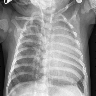

In [23]:
# Display an example image
array_to_img(images[0])

In [24]:
# Display an example label
labels[0]

array([0., 0., 1.], dtype=float32)

##### Modeling

In [25]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [26]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [27]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [28]:
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [29]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

In [30]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(3, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [31]:
# Build the model
model1 = build_model()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4608)            

In [32]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [33]:
# fit the neural network
epochs=25
history = model1.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks = get_callbacks())

Epoch 1/25


151/151 [==============================] - 59s 369ms/step - loss: 0.6116 - accuracy: 0.7475 - val_loss: 0.4888 - val_accuracy: 0.8263
Epoch 2/25
151/151 [==============================] - 4s 26ms/step - loss: 0.4275 - accuracy: 0.8452 - val_loss: 0.3998 - val_accuracy: 0.8641
Epoch 3/25
151/151 [==============================] - 4s 26ms/step - loss: 0.3510 - accuracy: 0.8816 - val_loss: 0.3710 - val_accuracy: 0.8881
Epoch 4/25
151/151 [==============================] - 4s 27ms/step - loss: 0.3153 - accuracy: 0.8963 - val_loss: 0.3453 - val_accuracy: 0.8924
Epoch 5/25
151/151 [==============================] - 4s 24ms/step - loss: 0.2786 - accuracy: 0.9031 - val_loss: 0.3430 - val_accuracy: 0.8859
Epoch 6/25
151/151 [==============================] - 4s 28ms/step - loss: 0.2613 - accuracy: 0.9108 - val_loss: 0.3498 - val_accuracy: 0.8939
Epoch 7/25
151/151 [==============================] - 4s 27ms/step - loss: 0.2456 - accuracy: 0.9168 - val_loss: 0.3379 - val_accuracy: 0.

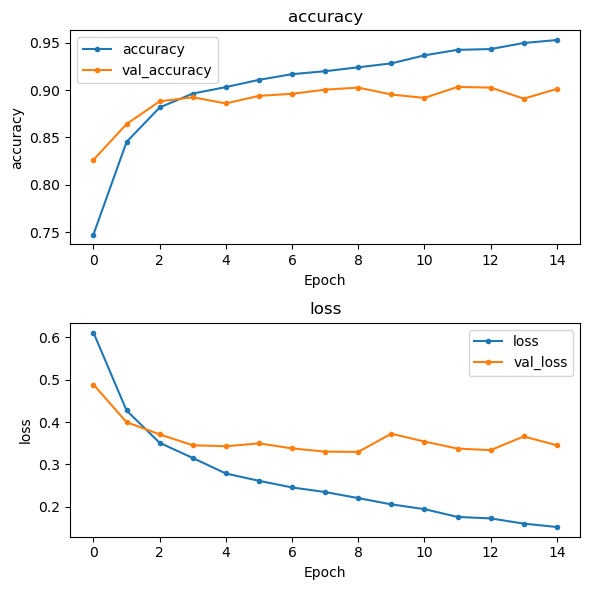


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1587
           1       0.95      0.95      0.95      1623
           2       0.97      0.95      0.96      1622

    accuracy                           0.96      4832
   macro avg       0.96      0.96      0.96      4832
weighted avg       0.96      0.96      0.96      4832



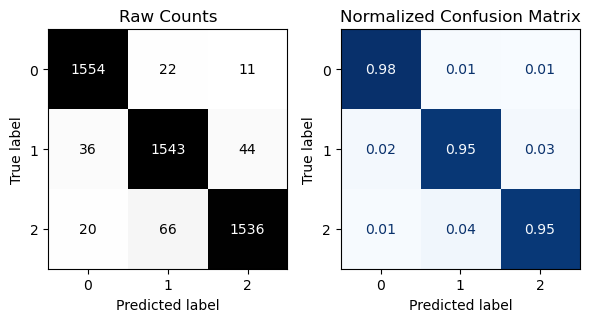


- Evaluating Training Data:
151/151 [==============================] - 2s 12ms/step - loss: 0.1288 - accuracy: 0.9588
{'loss': 0.12876112759113312, 'accuracy': 0.9588162302970886}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       216
           1       0.90      0.87      0.88       252
           2       0.89      0.91      0.90       226

    accuracy                           0.90       694
   macro avg       0.90      0.90      0.90       694
weighted avg       0.90      0.90      0.90       694



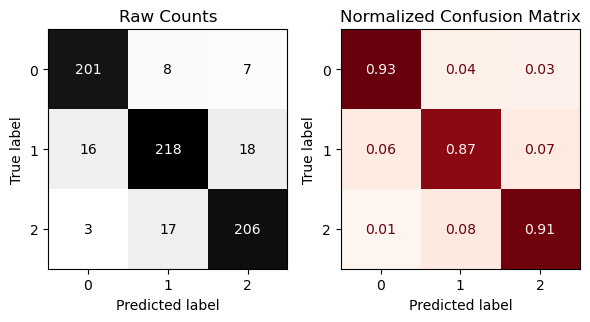


- Evaluating Test Data:
22/22 [==============================] - 0s 14ms/step - loss: 0.3563 - accuracy: 0.9006
{'loss': 0.3562898337841034, 'accuracy': 0.9005763530731201}


In [34]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    model1, X_train=train_ds, X_test=test_ds, history=history);

In [42]:
def build_model_dense():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Second Concolutional layer
    model.add(
        layers.Conv2D(
            filters=16,
            kernel_size=3,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        )) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Flattening layer
    model.add(layers.Flatten())
    # Hidden Dense layer
    model.add(
        layers.Dense(32, activation="relu")
    )
    # Output layer
    model.add(
        layers.Dense(3, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [43]:
# Build the model
model2 = build_model_dense()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 96, 96, 8)         224       
                                                                 
 conv2d_10 (Conv2D)          (None, 96, 96, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 48, 48, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 8)         1160      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 8)         0         
 g2D)                                                 

In [44]:
# fit the neural network
epochs=25
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks = get_callbacks())

Epoch 1/25
151/151 [==============================] - 19s 103ms/step - loss: 0.5423 - accuracy: 0.7904 - val_loss: 0.3978 - val_accuracy: 0.8699
Epoch 2/25
151/151 [==============================] - 10s 66ms/step - loss: 0.3328 - accuracy: 0.8893 - val_loss: 0.3383 - val_accuracy: 0.8844
Epoch 3/25
151/151 [==============================] - 11s 73ms/step - loss: 0.2491 - accuracy: 0.9162 - val_loss: 0.3181 - val_accuracy: 0.9055
Epoch 4/25
151/151 [==============================] - 10s 67ms/step - loss: 0.2089 - accuracy: 0.9303 - val_loss: 0.2528 - val_accuracy: 0.9266
Epoch 5/25
151/151 [==============================] - 12s 81ms/step - loss: 0.1617 - accuracy: 0.9452 - val_loss: 0.2795 - val_accuracy: 0.9164
Epoch 6/25
151/151 [==============================] - 8s 56ms/step - loss: 0.1363 - accuracy: 0.9503 - val_loss: 0.2473 - val_accuracy: 0.9244
Epoch 7/25
151/151 [==============================] - 10s 69ms/step - loss: 0.1029 - accuracy: 0.9642 - val_loss: 0.2662 - val_accuracy:

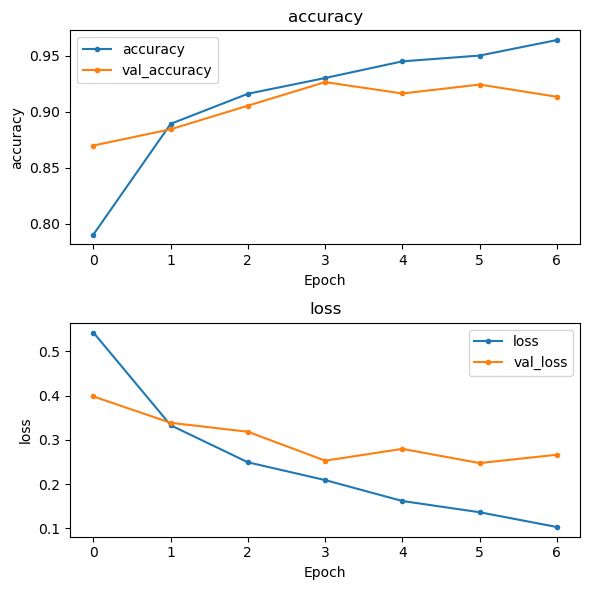


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1587
           1       0.97      0.96      0.96      1623
           2       0.98      0.97      0.97      1622

    accuracy                           0.97      4832
   macro avg       0.97      0.97      0.97      4832
weighted avg       0.97      0.97      0.97      4832



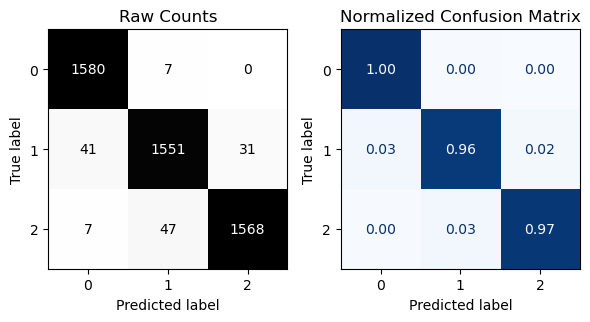


- Evaluating Training Data:
151/151 [==============================] - 4s 25ms/step - loss: 0.0843 - accuracy: 0.9725
{'loss': 0.08425828069448471, 'accuracy': 0.9724751710891724}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       216
           1       0.88      0.85      0.86       252
           2       0.91      0.89      0.90       226

    accuracy                           0.89       694
   macro avg       0.89      0.89      0.89       694
weighted avg       0.89      0.89      0.89       694



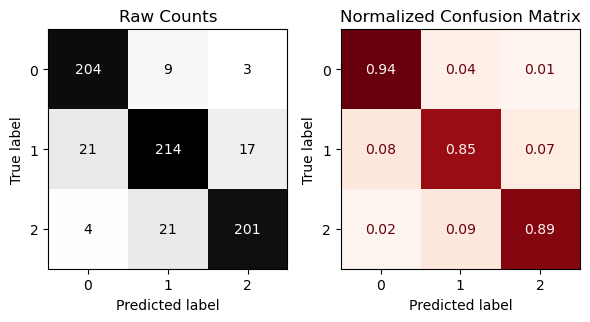


- Evaluating Test Data:
22/22 [==============================] - 1s 26ms/step - loss: 0.2945 - accuracy: 0.8919
{'loss': 0.29448118805885315, 'accuracy': 0.8919308185577393}


In [45]:
# Evaluate the model using the evaluation function
evaluate_classification_network(
    model2, X_train=train_ds, X_test=test_ds, history=history);

In [48]:
!pip install visualkeras

  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/04/0b/52a3be50d3421977d779a159f6be484e7aa2c5304f6278ede5ed7c491ef5/aggdraw-1.3.18-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/44.9 kB ? eta -:--:--
   --------- ------------------------------ 10.2/44.9 kB ? eta -:--:--
   --------- ------------------------------ 10.2/44.9 kB ? eta -:--:--
   ------------------ --------------------- 20.5/44.9 kB 131.3 kB/s eta 0:00:01
   --------------------------- ------------ 30.7/44.9 kB 131.3 kB/s eta 0:00:01
   --------------------------- ------------ 30.7/44.9 kB 131.3 kB/s eta 0:00:01
   --------------------------- ------------ 30.7/44.9 kB 131.3 kB/s eta 0:00:01
   ------------------------------------ --- 41.0/44.9 kB 103.8 kB/s eta 0:00:01
   ---------------------------------------- 44.9/44.9 kB 105.6 kB/s eta 0:00:00


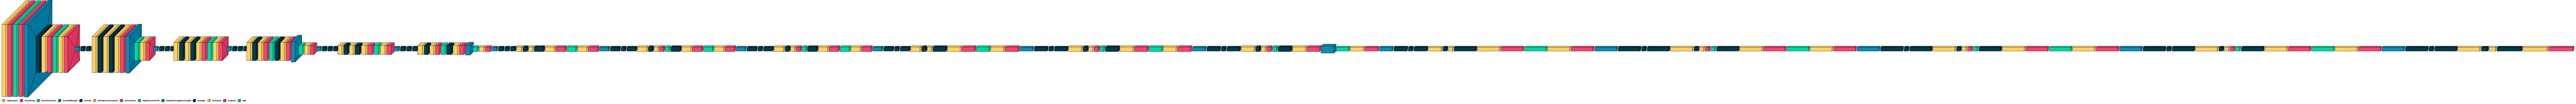

In [49]:
# Import vk
import visualkeras as vk
tf.__version__

# Download EfficientNet base
efficientnet_base =tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)

# Make it not-trainable
efficientnet_base.trainable=False
vk.layered_view(efficientnet_base, legend=True)

In [50]:
# add preprocessing lambda layer
lambda_layer_efficient = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, 
                                      name='preprocess_input_enet')

def build_efficientnet_model():
    model = models.Sequential(name="EfficientNetB0")
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_efficient)

    # Add pretrained base
    model.add(efficientnet_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input_enet (Lam  (None, 96, 96, 3)         0         
 bda)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 3, 3, 1280)        4049571   
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 11520)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               2949376   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)              

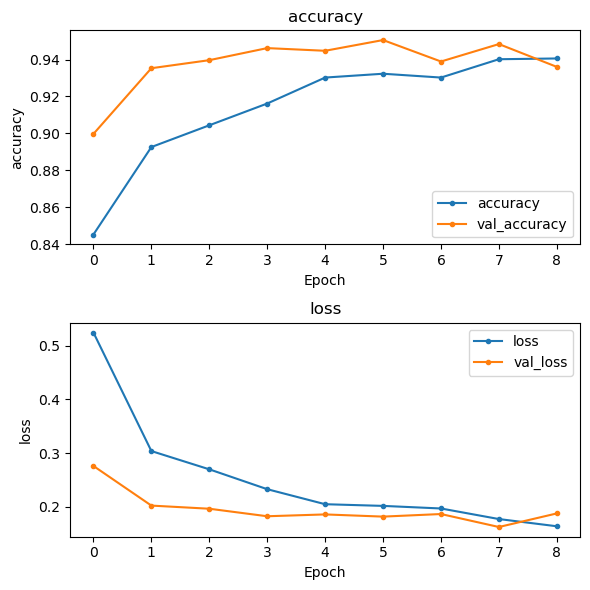


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       216
           1       0.91      0.87      0.89       252
           2       0.93      0.92      0.92       226

    accuracy                           0.91       694
   macro avg       0.92      0.92      0.92       694
weighted avg       0.92      0.91      0.91       694



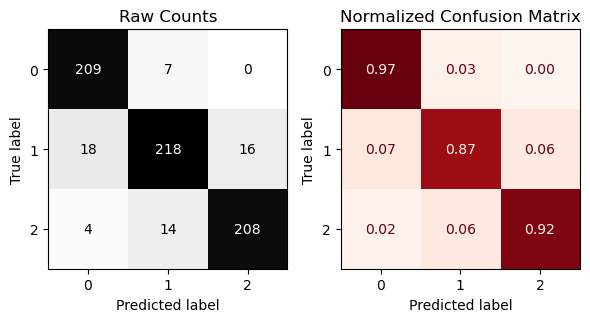


- Evaluating Test Data:
22/22 [==============================] - 5s 227ms/step - loss: 0.2499 - accuracy: 0.9150
{'loss': 0.2498641163110733, 'accuracy': 0.9149855971336365}


In [51]:
# Build, fit, and evaluate EfficientNet Model
model_effnet = build_efficientnet_model()
history = model_effnet.fit(train_ds, validation_data=val_ds,epochs=25, 
                    callbacks=get_callbacks()
                   )
evaluate_classification_network(model_effnet, X_test=test_ds, history=history);

In [53]:
# Save the model as a .keras file using model.save()
saved_model = model_effnet.save('model_effnet.h5')

**Model1:**
- Accuracy 96% on training data, 90% on test data
- val_loss: 0.3453

**Model2:**
- Accuracy 97% on training data, 89% on test data
- val_loss: 0.2662

**Model3 (efficient model):**
- Accuracy 91% on test data
- val_loss: 0.1878

**Model3 (efficient model) is the best with the highest accuracy (91%) and lowest validation loss (0.1878)**